## What are the peak and low season months for EV sales based on the data from 2022 to 2024? 

Here how you can solve it

---

1. Load the data
2. Convert the datetime into pandas datetime
3. Aggregate sales by month
4. Find peak month by getting the max sales of that month and opposite for low_month

In [2]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pt
import plotly.express as ex
from IPython.display import display

In [3]:
# Loading the ev_sales dataset
ev_sales = pd.read_csv("../../data/processed/electric_vehicle_sales_by_state.csv")
dim_date = pd.read_csv('../../data/raw/dim_date.csv')

display(ev_sales.head(1))
display(ev_sales.columns)

,date,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold
0,01-Apr-21,Sikkim,2-Wheelers,0,398


Index(['date', 'state', 'vehicle_category', 'electric_vehicles_sold',
       'total_vehicles_sold'],
      dtype='object')

In [4]:
ev_sales = pd.merge(dim_date, ev_sales, on='date', how='inner')

In [5]:
# convert datetime into pandas datetime
ev_sales["date"] = pd.to_datetime(ev_sales["date"], errors="coerce")
ev_sales["month_name"] = ev_sales["date"].dt.month_name()
ev_sales["month"] = ev_sales["date"].dt.month


# Filter for fiscal years 2022-2024
ev_sales = ev_sales[ev_sales["fiscal_year"].between(2022, 2024)]

/tmp/ipykernel_328693/209592305.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ev_sales["date"] = pd.to_datetime(ev_sales["date"], errors="coerce")


In [6]:
# Aggregate month of ev_sales by sales
"""
We want total sales per month across all years (or average per month):
"""

monthly_sales = (
    ev_sales.groupby(["month", "month_name"])["electric_vehicles_sold"]
    .sum()
    .reset_index()
    .sort_values(by="month", ascending=True)
)

display(monthly_sales)

,month,month_name,electric_vehicles_sold
0,1,January,189099
1,2,February,198049
2,3,March,291587
3,4,April,134657
4,5,May,159869
5,6,June,106709
6,7,July,127426
7,8,August,141961
8,9,September,145972
9,10,October,185185


In [7]:
# find peaks and lowld season months

peak_month = monthly_sales.loc[monthly_sales['electric_vehicles_sold'].idxmax(), 'month_name']
low_month = monthly_sales.loc[monthly_sales['electric_vehicles_sold'].idxmin(), 'month_name']

print(f"Peak month for EV sales: {peak_month}")
print(f"Low month for EV sales: {low_month}")

Peak month for EV sales: March
Low month for EV sales: June


/tmp/ipykernel_328693/1779725159.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="month_name", y="electric_vehicles_sold", data=monthly_sales, palette="viridis")


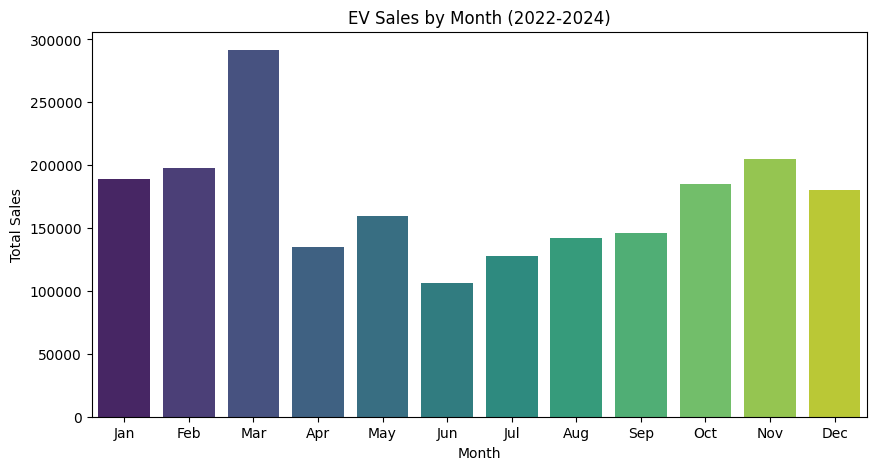

In [8]:
plt.figure(figsize=(10, 5))
sns.barplot(x="month_name", y="electric_vehicles_sold", data=monthly_sales, palette="viridis")

plt.title("EV Sales by Month (2022-2024)")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(
    range(0, 12),
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
)
plt.show()

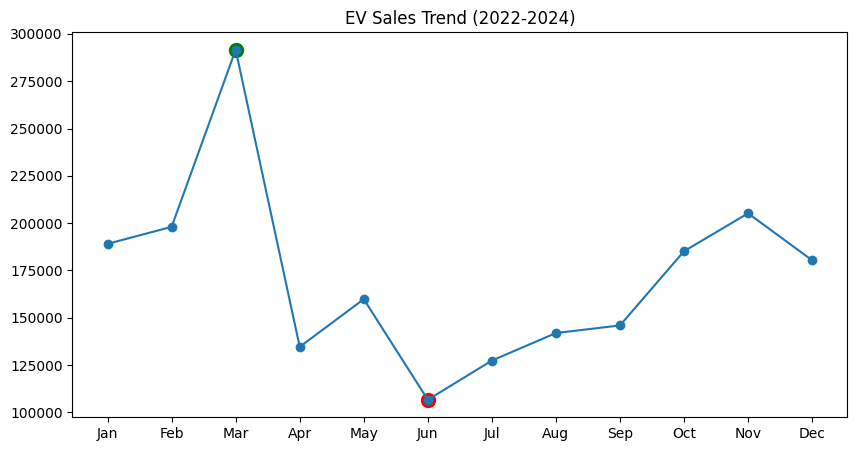

In [9]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['month_name'], monthly_sales['electric_vehicles_sold'], marker='o')
plt.scatter(peak_month, monthly_sales.loc[monthly_sales['month_name']==peak_month, 'electric_vehicles_sold'], color='green', s=100)
plt.scatter(low_month, monthly_sales.loc[monthly_sales['month_name']==low_month, 'electric_vehicles_sold'], color='red', s=100)
plt.xticks(range(0,12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('EV Sales Trend (2022-2024)')
plt.show()


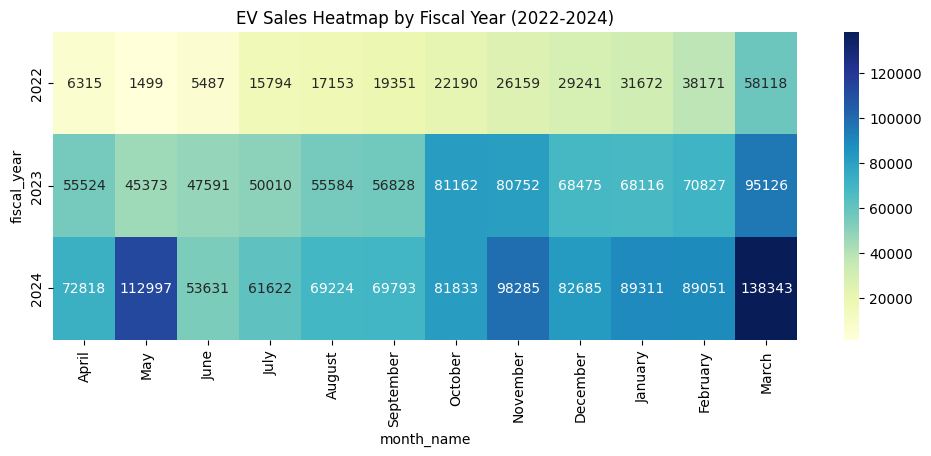

In [10]:
yearly_monthly_sales = (
    ev_sales[ev_sales["fiscal_year"].between(2022, 2024)]
    .groupby(["fiscal_year", "month_name"])["electric_vehicles_sold"]
    .sum()
    .reset_index()
)

# Create the pivot table
sales_pivot = yearly_monthly_sales.pivot(
    index="fiscal_year", columns="month_name", values="electric_vehicles_sold"
)

# Reorder columns to show months in chronological order (starting from April)
fiscal_month_order = [
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
    "January",
    "February",
    "March",
]
sales_pivot = sales_pivot[fiscal_month_order]

# Create the heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(sales_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("EV Sales Heatmap by Fiscal Year (2022-2024)")
plt.show()

In [12]:
import pandas as pd

df = pd.read_csv("../../data/processed/electric_vehicle_sales_by_state.csv")
dim_date = pd.read_csv("../../data/raw/dim_date.csv")

df['date'] = pd.to_datetime(df['date'])
dim_date['date'] = pd.to_datetime(dim_date['date'])

ev_sales = pd.merge(dim_date, df, on='date', how='inner')

# 1. Calculate EV penetration for each state
state_penetration = (
    ev_sales.groupby('state')[['electric_vehicles_sold', 'total_vehicles_sold']]
    .sum()
    .reset_index()
)
state_penetration['ev_penetration'] = (
    state_penetration['electric_vehicles_sold'] / state_penetration['total_vehicles_sold']
) * 100

# 2. Calculate CAGR for each state (using yearly sales)
ev_sales['fiscal_year'] = pd.to_datetime(ev_sales['date']).dt.year
yearly_sales = (
    ev_sales.groupby(['state', 'fiscal_year'])['electric_vehicles_sold']
    .sum()
    .reset_index()
)

def calc_cagr(start, end, periods):
    return ((end / start) ** (1 / periods) - 1) * 100 if start > 0 and periods > 0 else 0

cagr_list = []
for state in yearly_sales['state'].unique():
    state_data = yearly_sales[yearly_sales['state'] == state].sort_values('fiscal_year')
    if len(state_data) >= 2:
        start_val = state_data.iloc[0]['electric_vehicles_sold']
        end_val = state_data.iloc[-1]['electric_vehicles_sold']
        periods = state_data.iloc[-1]['fiscal_year'] - state_data.iloc[0]['fiscal_year']
        cagr = calc_cagr(start_val, end_val, periods)
        cagr_list.append({'state': state, 'cagr': cagr})

cagr_df = pd.DataFrame(cagr_list)

# 3. Merge penetration and CAGR
state_maturity = pd.merge(
    state_penetration[['state', 'ev_penetration']], cagr_df, on='state'
)

# 4. Classify states by maturity and growth
def maturity_stage(pen):
    if pen > 15:
        return 'Advanced'
    elif pen > 5:
        return 'Developing'
    elif pen > 1:
        return 'Emerging'
    else:
        return 'Early'

def growth_tier(cagr):
    if cagr >= 80:
        return 'Hyper-Growth'
    elif cagr >= 50:
        return 'High-Growth'
    elif cagr >= 25:
        return 'Steady-Growth'
    else:
        return 'Emerging'

state_maturity['maturity_stage'] = state_maturity['ev_penetration'].apply(maturity_stage)

# Calculate maturity stage percentage distribution
maturity_percentage = (
    state_maturity['maturity_stage']
    .value_counts(normalize=True)
    .apply(lambda x: round(x * 100, 1))
    .to_dict()
)

# Map each state's maturity stage to its percentage share
state_maturity['maturity_percentage'] = state_maturity['maturity_stage'].map(maturity_percentage)

state_maturity['growth_tier'] = state_maturity['cagr'].apply(growth_tier)

display(state_maturity.head())

# 5. Summary statistics and lists
maturity_counts = state_maturity['maturity_stage'].value_counts(normalize=True) * 100
print('Maturity Stage Distribution (% of states):')
print(maturity_counts.round(1))

for tier in ['Hyper-Growth', 'High-Growth', 'Steady-Growth', 'Emerging']:
    states_in_tier = state_maturity[state_maturity['growth_tier'] == tier]['state'].tolist()
    print(f"{tier} Markets:", states_in_tier)


/tmp/ipykernel_335276/313604982.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipykernel_335276/313604982.py:7: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,state,ev_penetration,cagr,maturity_stage,maturity_percentage,growth_tier
0,Andaman & Nicobar Island,0.427984,-23.369057,Early,35.3,Emerging
1,Andhra Pradesh,3.389946,23.698849,Emerging,50.0,Emerging
2,Arunachal Pradesh,0.046124,0.000000,Early,35.3,Emerging
3,Assam,0.457360,57.971748,Early,35.3,High-Growth
4,Bihar,1.017559,28.139425,Emerging,50.0,Steady-Growth


Maturity Stage Distribution (% of states):
maturity_stage
Emerging      50.0
Early         35.3
Developing    14.7
Name: proportion, dtype: float64
Hyper-Growth Markets: ['Meghalaya', 'Tripura']
High-Growth Markets: ['Assam', 'Chhattisgarh', 'DNH and DD', 'Goa', 'Puducherry', 'Uttar Pradesh', 'West Bengal']
Steady-Growth Markets: ['Bihar', 'Chandigarh', 'Gujarat', 'Karnataka', 'Kerala', 'Ladakh', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Nagaland']
Emerging Markets: ['Andaman & Nicobar Island', 'Andhra Pradesh', 'Arunachal Pradesh', 'Delhi', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Mizoram', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Uttarakhand']


In [13]:
# Maturity Stage distribution table
maturity_distribution = (
    state_maturity['maturity_stage']
    .value_counts(normalize=True) * 100
).round(1).reset_index()

maturity_distribution.columns = ['Maturity Stage', 'Percentage']

# CAGR Performance Tier distribution table
growth_distribution = (
    state_maturity['growth_tier']
    .value_counts(normalize=True) * 100
).round(1).reset_index()

growth_distribution.columns = ['Growth Tier', 'Percentage']

print("Maturity Stage Distribution:")
print(maturity_distribution)

print("\nCAGR Performance Tier Distribution:")
print(growth_distribution)

# Optionally display as tables in notebook
display(maturity_distribution)
display(growth_distribution)

Maturity Stage Distribution:
  Maturity Stage  Percentage
0       Emerging        50.0
1          Early        35.3
2     Developing        14.7

CAGR Performance Tier Distribution:
     Growth Tier  Percentage
0       Emerging        44.1
1  Steady-Growth        29.4
2    High-Growth        20.6
3   Hyper-Growth         5.9


,Maturity Stage,Percentage
0,Emerging,50.0
1,Early,35.3
2,Developing,14.7


,Growth Tier,Percentage
0,Emerging,44.1
1,Steady-Growth,29.4
2,High-Growth,20.6
3,Hyper-Growth,5.9


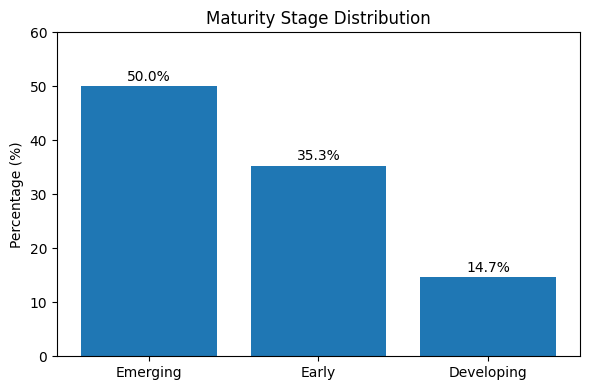

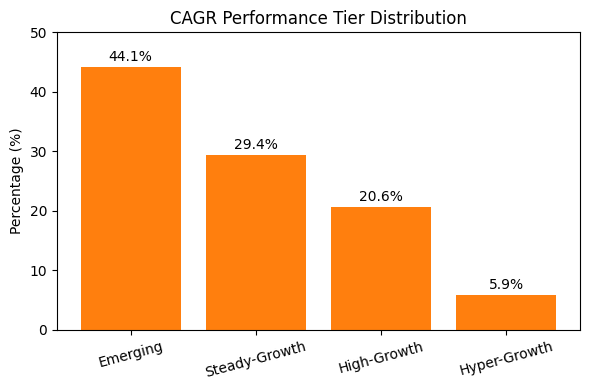

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
maturity_data = pd.DataFrame({
    "Maturity Stage": ["Emerging", "Early", "Developing"],
    "Percentage": [50.0, 35.3, 14.7]
})

cagr_data = pd.DataFrame({
    "Growth Tier": ["Emerging", "Steady-Growth", "High-Growth", "Hyper-Growth"],
    "Percentage": [44.1, 29.4, 20.6, 5.9]
})

# --- Plot Maturity Stage Distribution ---
plt.figure(figsize=(6, 4))
plt.bar(maturity_data["Maturity Stage"], maturity_data["Percentage"], color="#1f77b4")
plt.ylabel("Percentage (%)")
plt.title("Maturity Stage Distribution")
plt.ylim(0, 60)
for i, val in enumerate(maturity_data["Percentage"]):
    plt.text(i, val + 1, f"{val}%", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# --- Plot CAGR Tier Distribution ---
plt.figure(figsize=(6, 4))
plt.bar(cagr_data["Growth Tier"], cagr_data["Percentage"], color="#ff7f0e")
plt.ylabel("Percentage (%)")
plt.title("CAGR Performance Tier Distribution")
plt.ylim(0, 50)
plt.xticks(rotation=15)
for i, val in enumerate(cagr_data["Percentage"]):
    plt.text(i, val + 1, f"{val}%", ha='center', fontsize=10)
plt.tight_layout()
plt.show()


In [4]:
import plotly.express as px

# Scatter plot: EV Penetration vs CAGR
fig = px.scatter(
    state_maturity,
    x="ev_penetration",
    y="cagr",
    color="maturity_stage",
    symbol="growth_tier",
    hover_name="state",
    size="ev_penetration",
    title="EV Market Maturity vs Growth Tier by State",
    labels={
        "ev_penetration": "EV Penetration (%)",
        "cagr": "CAGR (%)",
        "maturity_stage": "Maturity Stage",
        "growth_tier": "Growth Tier"
    },
    width=900,
    height=600
)

fig.update_layout(
    xaxis=dict(tickformat=".1f"),
    yaxis=dict(tickformat=".1f"),
    legend_title_text='Market Segmentation',
    plot_bgcolor="white"
)

fig.show()


In [5]:
import plotly.express as px

# Count states by maturity stage and growth tier
summary_df = state_maturity.groupby(["maturity_stage", "growth_tier"]) \
    .size().reset_index(name="state_count")

# Sort maturity stages logically
stage_order = ["Early", "Emerging", "Developing", "Advanced"]
tier_order = ["Emerging", "Steady-Growth", "High-Growth", "Hyper-Growth"]

fig = px.bar(
    summary_df,
    x="maturity_stage",
    y="state_count",
    color="growth_tier",
    category_orders={"maturity_stage": stage_order, "growth_tier": tier_order},
    text="state_count",
    title="EV Market Maturity & Growth Tier Distribution",
    labels={
        "maturity_stage": "Market Maturity Stage",
        "state_count": "Number of States",
        "growth_tier": "Growth Tier"
    },
    barmode="group",
    width=900,
    height=500
)

fig.update_traces(textposition="outside")
fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig.show()


In [6]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(
    state_maturity,
    x="ev_penetration",
    y="cagr",
    color="growth_tier",
    hover_name="state",
    size_max=12,
    color_discrete_map={
        "Emerging": "#a6cee3",
        "Steady-Growth": "#1f78b4",
        "High-Growth": "#33a02c",
        "Hyper-Growth": "#e31a1c"
    },
    labels={
        "ev_penetration": "EV Penetration (%)",
        "cagr": "CAGR (%)"
    },
    title="EV Market Maturity Matrix",
    width=900,
    height=600
)

# Add vertical lines for maturity stage boundaries
fig.add_vline(x=1, line_dash="dash", line_color="gray")   # Early/Emerging
fig.add_vline(x=5, line_dash="dash", line_color="gray")   # Emerging/Developing
fig.add_vline(x=15, line_dash="dash", line_color="gray")  # Developing/Advanced

# Add horizontal lines for growth tier boundaries
fig.add_hline(y=25, line_dash="dash", line_color="gray")  # Emerging/Steady
fig.add_hline(y=50, line_dash="dash", line_color="gray")  # Steady/High
fig.add_hline(y=80, line_dash="dash", line_color="gray")  # High/Hyper

# Optional quadrant labels
quadrants = [
    {"x": 0.5, "y": 85, "text": "Hyper-Growth\nEarly/Emerging"},
    {"x": 10, "y": 85, "text": "Hyper-Growth\nDeveloping/Advanced"},
    {"x": 0.5, "y": 40, "text": "Steady/High Growth\nEarly/Emerging"},
    {"x": 10, "y": 40, "text": "Steady/High Growth\nDeveloping/Advanced"},
    {"x": 0.5, "y": 10, "text": "Emerging Growth\nEarly/Emerging"},
    {"x": 10, "y": 10, "text": "Emerging Growth\nDeveloping/Advanced"}
]

for q in quadrants:
    fig.add_annotation(
        x=q["x"], y=q["y"], text=q["text"],
        showarrow=False, font=dict(size=10, color="gray"), opacity=0.6
    )

fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()


In [8]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(
    state_maturity,
    x="ev_penetration",
    y="cagr",
    text="state",  # show state names on points
    color="maturity_stage",
    labels={
        "ev_penetration": "EV Penetration (%)",
        "cagr": "Annual Growth Rate (CAGR %)"
    },
    title="EV Market Maturity Matrix (States)",
    width=900,
    height=650
)

# Add maturity boundaries
fig.add_vline(x=1, line_dash="dash", line_color="black")   # Early/Emerging
fig.add_vline(x=5, line_dash="dash", line_color="black")   # Emerging/Developing
fig.add_vline(x=15, line_dash="dash", line_color="black")  # Developing/Advanced

# Add growth boundaries
fig.add_hline(y=25, line_dash="dash", line_color="black")  # Emerging/Steady
fig.add_hline(y=50, line_dash="dash", line_color="black")  # Steady/High
fig.add_hline(y=80, line_dash="dash", line_color="black")  # High/Hyper

# Quadrant labels (big & clear)
fig.add_annotation(x=0.5, y=90, text="Hyper Growth (Low Maturity)", showarrow=False, font=dict(size=14, color="red"))
fig.add_annotation(x=10, y=90, text="Hyper Growth (High Maturity)", showarrow=False, font=dict(size=14, color="red"))
fig.add_annotation(x=0.5, y=35, text="Steady/High Growth (Low Maturity)", showarrow=False, font=dict(size=14, color="green"))
fig.add_annotation(x=10, y=35, text="Steady/High Growth (High Maturity)", showarrow=False, font=dict(size=14, color="green"))
fig.add_annotation(x=0.5, y=10, text="Emerging Growth (Low Maturity)", showarrow=False, font=dict(size=14, color="blue"))
fig.add_annotation(x=10, y=10, text="Emerging Growth (High Maturity)", showarrow=False, font=dict(size=14, color="blue"))

# Make text readable
fig.update_traces(textposition='top center', marker=dict(size=12))

# Style
fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(showgrid=True, range=[0, max(state_maturity["ev_penetration"])+5]),
    yaxis=dict(showgrid=True, range=[0, max(state_maturity["cagr"])+10]),
    legend_title_text="Maturity Stage"
)

fig.show()
